In [1]:
#0.Import Libraries
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#0.Parameters
Coeff_window = 30

#1.Load csv
BTC_csv = 'Market_Bybit_BTCUSDT_1min_20250901-20250926'
ALT_csv = 'Market_Bybit_ASTERUSDT_1min_20250901-20250926'

df_BTC_raw = pd.read_csv(f'01.data/{BTC_csv}.csv')
df_Trade_raw = pd.read_csv(f'01.data/{ALT_csv}.csv')

#2.Merge csv
time_col, c_col = "timestamp", "C"
df_BTC = df_BTC_raw[[time_col, c_col]].copy()
df_BTC[time_col] = pd.to_datetime(df_BTC[time_col])
df_BTC = df_BTC.sort_values(time_col).rename(columns={c_col: "C_BTC"})

df_ALT = df_Trade_raw[[time_col, "O", "H", "L", "C"]].copy()
df_ALT[time_col] = pd.to_datetime(df_ALT[time_col])
df_ALT = df_ALT.sort_values(time_col).rename(columns={"O": "O_ALT", "H": "H_ALT", "L": "L_ALT", "C": "C_ALT"})

df_merged_raw = pd.merge(df_ALT[[time_col, "C_ALT"]], df_BTC, on=time_col, how="inner").reset_index(drop=True)

#3.Calc Log Return
df = df_merged_raw.copy()
df["ret_ALT"] = np.log(df["C_ALT"]).diff()
df["ret_BTC"] = np.log(df["C_BTC"]).diff()
df = df.dropna(subset=["ret_ALT", "ret_BTC"]).reset_index(drop=True)

#4.Calc Coefficient
minp = Coeff_window
mean_ALT = df["ret_ALT"].rolling(Coeff_window, min_periods=minp).mean()
mean_BTC = df["ret_BTC"].rolling(Coeff_window, min_periods=minp).mean()
var_BTC  = df["ret_BTC"].rolling(Coeff_window, min_periods=minp).var(ddof=0)
cov_AB   = df["ret_ALT"].rolling(Coeff_window, min_periods=minp).cov(df["ret_BTC"])

df["beta_BTC"] = cov_AB / var_BTC
df["alpha"] = mean_ALT - df["beta_BTC"] * mean_BTC

# print(df[[time_col, "ret_ALT", "ret_BTC", "alpha", "beta_BTC"]].tail(50))

#5.Calc Predicted return and Residual
df["ret_ALT_pred"] = df["alpha"] + df["beta_BTC"] * df["ret_BTC"]
df["resid"] = df["ret_ALT"] - df["ret_ALT_pred"]

#6.Standardize(ZScore)
resid_std = df["resid"].rolling(Coeff_window, min_periods=Coeff_window).std()
df["resid_z"] = df["resid"] / resid_std

# print(df[[time_col, "ret_ALT", "ret_BTC", "ret_ALT_pred", "resid", "resid_z"]].tail(20))

# ==============================
# ALTのOHLCVをマージ（ローソク足 & VWAP用）
# ==============================
# すでに df_ALT は O_ALT/H_ALT/L_ALT/C_ALT を持っているので、V も残す
if "V" in df_Trade_raw.columns:
    df_ALT_full = df_Trade_raw[[time_col, "O", "H", "L", "C", "V"]].copy()
else:
    # VがないCSVの保険（なければ疑似出来高=1）
    df_ALT_full = df_Trade_raw[[time_col, "O", "H", "L", "C"]].copy()
    df_ALT_full["V"] = 1.0

df_ALT_full[time_col] = pd.to_datetime(df_ALT_full[time_col])
df_ALT_full = df_ALT_full.sort_values(time_col).rename(columns={
    "O":"O_ALT","H":"H_ALT","L":"L_ALT","C":"C_ALT","V":"V_ALT"
})

# 価格・残差を持つ df と結合（timestamp基準）
df_all = pd.merge(df_ALT_full, df[[time_col, "ret_ALT", "ret_BTC", "alpha", "beta_BTC"]], 
                  on=time_col, how="inner").reset_index(drop=True)

#7.Calculate VWAP
vwap_window_short = 7
vwap_window_medium = 14

df_all["Typical_price"] = (df_all["O_ALT"]+df_all["H_ALT"]+df_all["L_ALT"]+df_all["C_ALT"])/4
df_all["TPxV"] = df_all["Typical_price"] * df_all["V_ALT"]

roll_tpv_s = df_all["TPxV"].rolling(vwap_window_short, min_periods=1).sum()
roll_v_s   = df_all["V_ALT"].rolling(vwap_window_short, min_periods=1).sum()
df_all["VWAP_short"] = roll_tpv_s / roll_v_s

roll_tpv_m = df_all["TPxV"].rolling(vwap_window_medium, min_periods=1).sum()
roll_v_m   = df_all["V_ALT"].rolling(vwap_window_medium, min_periods=1).sum()
df_all["VWAP_medium"] = roll_tpv_m / roll_v_m

#8.Calculate VWAP cross
df_all["Regeme_vwap"] = np.where(df_all["VWAP_short"] > df_all["VWAP_medium"], 1, 0)
reg_prev = df_all["Regeme_vwap"].shift(1)
reg_changed = (df_all["Regeme_vwap"] != reg_prev).fillna(False)

# 発火足（変化時のみ、値は新Regeme。そうでなければ NaN）
df_all["Trade_ignittion_vwap"] = np.where(reg_changed, df_all["Regeme_vwap"], np.nan)

# まずはVWAPクロス単独で Trade を作成（あなたのバックテスターに渡す用）
df_all["Trade"] = np.where(df_all["Trade_ignittion_vwap"].notna(), df_all["Regeme_vwap"], np.nan)

# ==== A) 残差 z を作る（まだなら） ====
# 係数から予想→残差→z（MADで頑丈に）
if "resid_z" not in df.columns:
    df["ret_ALT_pred"] = df["alpha"] + df["beta_BTC"] * df["ret_BTC"]
    df["resid"] = df["ret_ALT"] - df["ret_ALT_pred"]

    def rolling_mad(s):
        m = s.median()
        return 1.4826 * (np.abs(s - m)).median()

    resid_scale = df["resid"].rolling(Coeff_window, min_periods=Coeff_window)\
                             .apply(rolling_mad, raw=False)
    df["resid_z"] = df["resid"] / resid_scale

# ==== B) df_all に resid_z を結合 ====
df_all = pd.merge(df_all, df[[time_col, "resid_z"]], on=time_col, how="left")

# ==== C) 残差フィルターを掛けて Trade を更新 ====
k = 1           # しきい値（まずは±2σ）
persist_n = 1     # 連続本数（ノイズ削りたいなら 2〜3 に）

gate_abs = (df_all["resid_z"].abs() > k)
gate_persist = gate_abs.rolling(persist_n, min_periods=persist_n).sum() == persist_n

# 既存の発火足にフィルターをAND
df_all["Trade"] = np.where(
    df_all["Trade_ignittion_vwap"].notna() & gate_persist,
    df_all["Regeme_vwap"],
    np.nan
)

# # ==== D) 方向一致フィルター ====
# gate_dir = ((df_all["resid_z"] > 0) & (df_all["Regeme_vwap"] == 1)) | \
#            ((df_all["resid_z"] < 0) & (df_all["Regeme_vwap"] == 0))

# # 既存の gate_persist と組み合わせる
# df_all["Trade"] = np.where(
#     df_all["Trade_ignittion_vwap"].notna() & gate_persist & gate_dir,
#     df_all["Regeme_vwap"],
#     np.nan
# )

# （任意）“方向も一致してる時だけ”にしたい場合は↓
gate_dir = ((df_all["resid_z"] > 0) & (df_all["Regeme_vwap"] == 1)) | \
           ((df_all["resid_z"] < 0) & (df_all["Regeme_vwap"] == 0))
df_all["Trade"] = np.where(
    df_all["Trade_ignittion_vwap"].notna() & gate_persist & gate_dir,
    df_all["Regeme_vwap"], np.nan
)

# 動作確認
print(df_all[[time_col,"C_ALT","VWAP_short","VWAP_medium","Regeme_vwap","Trade_ignittion_vwap","Trade"]].tail(10))

#10.Backtest
# バックテスターが期待する列名に合わせる
df_bt = df_all.rename(columns={"C_ALT": "C", "V_ALT": "V"}).copy()

# 念のための整列＆必須列チェック
df_bt = df_bt.sort_values("timestamp").reset_index(drop=True)
assert {"timestamp","C","V","Trade"}.issubset(df_bt.columns)

# A) フィルターなし（純VWAPクロス）
df_bt_A = df_bt.copy()
df_bt_A["Trade"] = np.where(df_bt_A["Trade_ignittion_vwap"].notna(),
                            df_bt_A["Regeme_vwap"], np.nan)

# B) 残差フィルターあり（すでに df_all で作った gate_dir/persist を反映済の Trade を使用）
df_bt_B = df_bt.copy()  # こちらは df_all["Trade"] をそのまま使う


# ==============================
#  Backtest (notional-based, linear, fee per side)
# ==============================
def run_backtest(
    df_in: pd.DataFrame,
    initial_capital: float = 1000.0,   # 現金（証拠金口座の初期残高イメージ）
    fee: float = 0.00055,              # 片道手数料（例: 0.055%）
    notional_size: float = 100.0,      # 建玉の名目USDサイズ（レバ有り想定）
    min_qty: float = 0.0               # 取引所の最小数量があれば指定（無ければ0）
) -> pd.DataFrame:
    """
    ルール:
      - df['Trade'] が 1=ロング点灯, 0=ショート点灯, NaN=何もしない
      - 既存ポジがあるとき: 逆方向が点灯したらドテン（クローズ→新規オープン）
                             同方向が点灯したら何もしない（ピラミッディング無し）
      - 手数料は「取引が発生したバー」に即時計上（fee * price * abs(trade_qty)）
      - 含み損益は各バー終値Cで評価
      - エクイティ = initial_capital + realized_pnl_cum + unrealized_pnl - fee_cum
    """
    d = df_in.copy()

    n = len(d)
    # 出力列（初期化）
    side = np.zeros(n, dtype=int)                 # -1/0/1
    pos_qty = np.zeros(n, dtype=float)            # 建玉数量（+ロング/-ショート）
    entry_price = np.full(n, np.nan, dtype=float) # 現在ポジの平均建値
    trade_qty = np.zeros(n, dtype=float)          # そのバーで新規に取引した数量（+買/-売）
    trade_notional = np.zeros(n, dtype=float)     # そのバーの取引名目
    fee_paid = np.zeros(n, dtype=float)           # そのバーの手数料
    fee_cum = np.zeros(n, dtype=float)

    realized_pnl = np.zeros(n, dtype=float)       # そのバーで実現したPnL（クローズ時のみ）
    realized_pnl_cum = np.zeros(n, dtype=float)

    unrealized_pnl = np.zeros(n, dtype=float)     # 含み損益（バー終値で評価）
    equity = np.zeros(n, dtype=float)

    # 内部ステート
    cur_qty = 0.0
    cur_entry = np.nan
    cur_realized = 0.0
    cur_fee_cum = 0.0

    for i in range(n):
        price = float(d.at[i, "C"])  # 終値で評価・発注
        sig = d.at[i, "Trade"]       # 1,0, or NaN

        # --- 取引判定 ---
        do_trade = False
        desired_side = 0
        if pd.notna(sig):
            desired_side = 1 if sig == 1 else -1
            # flat → 新規 / 逆向き → ドテン / 同向き → 何もしない
            if cur_qty == 0.0:
                do_trade = True
            else:
                cur_side = 1 if cur_qty > 0 else -1
                if desired_side == -cur_side:
                    do_trade = True  # ドテン
                # 同方向は何もしない

        # --- 約定処理 ---
        if do_trade:
            # まず既存ポジをクローズ（ドテン or フラット→新規のいずれでも、クローズ分があれば）
            if cur_qty != 0.0:
                close_qty = -cur_qty  # 既存をゼロに戻す方向
                # 実現PnL（線形）：(price - entry) * qty
                pnl_close = (price - cur_entry) * cur_qty
                cur_realized += pnl_close

                # 手数料（クローズ分）
                close_notional = abs(close_qty) * price
                fee_close = fee * close_notional
                cur_fee_cum += fee_close

                # ログ
                trade_qty[i] += close_qty
                trade_notional[i] += close_notional
                fee_paid[i] += fee_close
                realized_pnl[i] += pnl_close

                # ポジションを一旦フラット
                cur_qty = 0.0
                cur_entry = np.nan

            # 次に desired_side の新規建玉を作る
            if desired_side != 0:
                target_qty = notional_size / price  # 名目USD / 価格 = 数量
                if min_qty and min_qty > 0:
                    # 切り捨て（足りなければ0に）
                    target_qty = np.floor(target_qty / min_qty) * min_qty
                target_qty = float(target_qty)
                if target_qty > 0:
                    open_qty = desired_side * target_qty
                    open_notional = abs(open_qty) * price
                    fee_open = fee * open_notional
                    cur_fee_cum += fee_open

                    # ログ
                    trade_qty[i] += open_qty
                    trade_notional[i] += open_notional
                    fee_paid[i] += fee_open

                    # ポジション更新（ここでは平均値=発注価格）
                    cur_qty = open_qty
                    cur_entry = price

        # --- 含み損益 & エクイティ評価 ---
        u_pnl = (price - cur_entry) * cur_qty if cur_qty != 0.0 else 0.0
        unrealized_pnl[i] = u_pnl

        # 累積
        if i > 0:
            realized_pnl_cum[i] = realized_pnl_cum[i-1] + realized_pnl[i]
            fee_cum[i] = fee_cum[i-1] + fee_paid[i]
        else:
            realized_pnl_cum[i] = realized_pnl[i]
            fee_cum[i] = fee_paid[i]

        equity[i] = initial_capital + realized_pnl_cum[i] + unrealized_pnl[i] - fee_cum[i]

        # 表示用の状態
        pos_qty[i] = cur_qty
        entry_price[i] = cur_entry
        side[i] = 0 if cur_qty == 0 else (1 if cur_qty > 0 else -1)

    out = d.copy()
    out["side"] = side
    out["position_qty"] = pos_qty
    out["entry_price"] = entry_price
    out["trade_qty"] = trade_qty
    out["trade_notional"] = trade_notional
    out["fee_paid"] = fee_paid
    out["fee_paid_cum"] = fee_cum
    out["realized_pnl"] = realized_pnl
    out["realized_pnl_cum"] = realized_pnl_cum
    out["unrealized_pnl"] = unrealized_pnl
    out["equity"] = equity
    return out


# 例）taker前提でやや高めの手数料（0.055%）・名目サイズ200USD
bt_A = run_backtest(df_bt_A, initial_capital=1000.0, fee=0.00035, notional_size=1000.0, min_qty=0.0)
bt_B = run_backtest(df_bt_B, initial_capital=1000.0, fee=0.00035, notional_size=1000.0, min_qty=0.0)

def summary(bt, tag):
    total_fee = bt['fee_paid'].sum()
    trade_count_bars = (bt['trade_qty'] != 0).sum()
    total_notional = bt['trade_notional'].sum()
    print(f"=== {tag} ===")
    print(f"Total fee paid     : {total_fee:.2f} USD")
    print(f"Number of trade bars: {trade_count_bars}")
    print(f"Total trade notional: {total_notional:.2f} USD")
    print(f"Final equity        : {bt['equity'].iloc[-1]:.2f} USD")

summary(bt_A, "VWAP only")
summary(bt_B, "VWAP + Residual gate")

# Equity曲線（plotly.go）
fig = go.Figure()
fig.add_trace(go.Scatter(x=bt_A['timestamp'], y=bt_A['equity'], mode='lines', name='VWAP only'))
fig.add_trace(go.Scatter(x=bt_B['timestamp'], y=bt_B['equity'], mode='lines', name='VWAP + Residual gate'))
fig.update_layout(title="Equity Curve Comparison", xaxis_title="Time", yaxis_title="Equity (USD)",
                  hovermode="x unified", template="plotly_white", height=500, width=1200)
fig.show()




               timestamp   C_ALT  VWAP_short  VWAP_medium  Regeme_vwap  \
9265 2025-09-25 19:51:00  1.9543    1.968973     1.976357            0   
9266 2025-09-25 19:52:00  1.9632    1.964853     1.973894            0   
9267 2025-09-25 19:53:00  1.9756    1.963616     1.972573            0   
9268 2025-09-25 19:54:00  1.9751    1.963579     1.970885            0   
9269 2025-09-25 19:55:00  1.9915    1.966548     1.970224            0   
9270 2025-09-25 19:56:00  1.9782    1.969261     1.971236            0   
9271 2025-09-25 19:57:00  1.9710    1.970910     1.970886            1   
9272 2025-09-25 19:58:00  1.9695    1.972297     1.970462            1   
9273 2025-09-25 19:59:00  1.9704    1.976695     1.969446            1   
9274 2025-09-25 20:00:00  1.9729    1.977371     1.969336            1   

      Trade_ignittion_vwap  Trade  
9265                   NaN    NaN  
9266                   NaN    NaN  
9267                   NaN    NaN  
9268                   NaN    NaN  
9269 

In [5]:
実務の流れ（コード抜きの手順）

データを合わせる：アルト・BTC（＋ETH）の1分リターン。時刻は完全一致。

窓を決める：30〜60本（銘柄で調整）。

係数を出す：上の①（ローリングOLS）をまず採用。

予想を作る：pred = a + b1*ret_BTC (+ b2*ret_ETH)

残差 = 実際 − 予想 を計算 → これが「独自の動き」。

標準化：直近の残差の振れ幅で割って“どれくらい大きいズレか”を見る（zスコア）。

ゲート：|z|がしきい値（例2.0）超え、かつ向き一致の時だけ既存シグナルを有効化。

SyntaxError: invalid character '（' (U+FF08) (4210246796.py, line 1)

In [6]:
df_merged_raw

,timestamp,C_ALT,C_BTC
0,2025-09-19 09:25:00,0.7000,116805.8
1,2025-09-19 09:26:00,0.7000,116807.3
2,2025-09-19 09:27:00,0.7000,116777.8
3,2025-09-19 09:28:00,0.7000,116724.5
4,2025-09-19 09:29:00,0.7000,116759.6
...,...,...,...
9271,2025-09-25 19:56:00,1.9782,109406.7
9272,2025-09-25 19:57:00,1.9710,109332.6
9273,2025-09-25 19:58:00,1.9695,109311.4
9274,2025-09-25 19:59:00,1.9704,109332.3


In [7]:
# （resid, resid_z が未作成なら先に計算しておく想定）

# 可視化用データ：ALTのOHLCに resid_z を結合
plot_df = pd.merge(
    df_ALT,                          # O_ALT, H_ALT, L_ALT, C_ALT を含む
    df[[time_col, "resid_z"]],       # 残差z
    on=time_col, how="left"
).sort_values(time_col)

# ローソク足 + 残差z
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.05, row_heights=[0.65, 0.35],
                    subplot_titles=("ALT Price", "Residual z-score vs BTC model"))

fig.add_trace(go.Candlestick(
    x=plot_df[time_col],
    open=plot_df["O_ALT"], high=plot_df["H_ALT"],
    low=plot_df["L_ALT"], close=plot_df["C_ALT"],
    name="ALT OHLC"
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=plot_df[time_col], y=plot_df["resid_z"],
    mode="lines", name="resid z"
), row=2, col=1)

k = 2.0
fig.add_trace(go.Scatter(x=plot_df[time_col], y=[k]*len(plot_df),
                         mode="lines", name=f"+{k}σ", line=dict(dash="dash")), row=2, col=1)
fig.add_trace(go.Scatter(x=plot_df[time_col], y=[-k]*len(plot_df),
                         mode="lines", name=f"-{k}σ", line=dict(dash="dash")), row=2, col=1)
fig.add_trace(go.Scatter(x=plot_df[time_col], y=[0]*len(plot_df),
                         mode="lines", name="0", line=dict(dash="dot")), row=2, col=1)

fig.update_layout(hovermode="x unified", showlegend=True,
                  margin=dict(l=40, r=20, t=60, b=40),
                  height=900, width=1400)
fig.update_xaxes(rangeslider_visible=False)
fig.show()


In [8]:
H_list = [1,3,5]          # 1/3/5分先
k = 2.0                   # 閾値
out = []
for H in H_list:
    fut = np.log(df["C_ALT"]).shift(-H) - np.log(df["C_ALT"])
    sample = df[(df["resid_z"].abs()>k)].copy()
    # 方向一致（ロング: z>0 & fut>0、ショート: z<0 & fut<0）
    hit = ((sample["resid_z"]>0) & (fut>0)) | ((sample["resid_z"]<0) & (fut<0))
    out.append({
        "H": H,
        "N(trades)": hit.count(),
        "HitRate": hit.mean(),
        "Avg fut ret (bp)": (fut.loc[sample.index].mean()*1e4)
    })
pd.DataFrame(out)


,H,N(trades),HitRate,Avg fut ret (bp)
0,1,9275,0.022857,12.842540
1,3,9275,0.020809,20.225537
2,5,9275,0.022102,27.495143


In [9]:
q = pd.qcut(df["resid_z"].abs().dropna(), 10, labels=False)
tmp = df.loc[q.index].copy()
tmp["bin"] = q
H = 3
fut = np.log(df["C_ALT"]).shift(-H) - np.log(df["C_ALT"])
res = tmp.groupby("bin").apply(lambda g: pd.Series({
    "N": len(g),
    "HitRate": (((g["resid_z"]>0)&(fut.loc[g.index]>0))|((g["resid_z"]<0)&(fut.loc[g.index]<0))).mean(),
    "AvgFut(bp)": (fut.loc[g.index].mean()*1e4)
})).reset_index()
res


,bin,N,HitRate,AvgFut(bp)
0,0,922.0,0.527115,6.160694
1,1,922.0,0.496746,0.222220
2,2,921.0,0.515744,1.430570
3,3,922.0,0.505423,6.522449
4,4,922.0,0.503254,3.726178
5,5,921.0,0.503800,-1.676443
6,6,922.0,0.519523,-1.094880
7,7,921.0,0.512486,5.720169
8,8,922.0,0.531453,0.409676
9,9,922.0,0.455531,16.146975


In [10]:
H=3
fut = np.log(df["C_ALT"]).shift(-H) - np.log(df["C_ALT"])
rows=[]
for k in [1.5, 2.0, 2.5, 3.0]:
    sample = df[df["resid_z"].abs()>k].copy()
    if len(sample)==0: 
        rows.append({"k":k,"N":0,"HitRate":np.nan,"AvgFut(bp)":np.nan}); continue
    hit = ((sample["resid_z"]>0)&(fut.loc[sample.index]>0))|((sample["resid_z"]<0)&(fut.loc[sample.index]<0))
    rows.append({"k":k,"N":len(sample),"HitRate":hit.mean(),
                 "AvgFut(bp)":(fut.loc[sample.index].mean()*1e4)})
pd.DataFrame(rows)


,k,N,HitRate,AvgFut(bp)
0,1.5,1191,0.477750,9.103876
1,2.0,445,0.433708,20.225537
2,2.5,157,0.394904,12.584742
3,3.0,49,0.387755,10.264603


<Axes: xlabel='z', ylabel='fut3'>

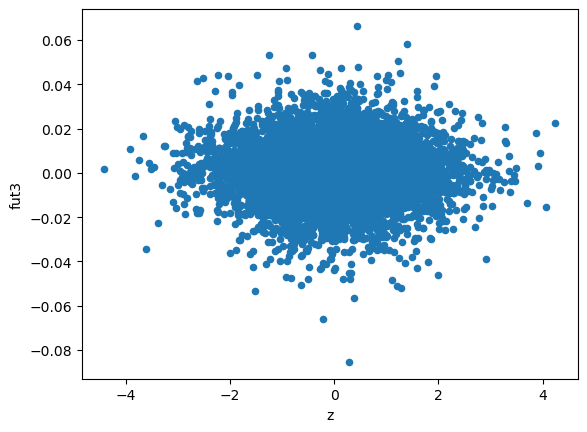

In [11]:
H=3
fut = np.log(df["C_ALT"]).shift(-H) - np.log(df["C_ALT"])
ax = pd.DataFrame({"z": df["resid_z"], f"fut{H}": fut}).dropna()
ax.plot(kind="scatter", x="z", y=f"fut{H}")
